In [1]:
from mplsoccer.pitch import Pitch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
import fuzzymatcher
import seaborn as sns
%config InlineBackend.figure_format='retina'

In [2]:
WYSCOUT = os.path.join('..', 'data', 'wyscout')
STATSBOMB = os.path.join('..', 'data', 'statsbomb')

Load data

In [3]:
df_wyscout_event = pd.read_parquet(os.path.join(WYSCOUT, 'event_overlap.parquet'))
df_wyscout_match = pd.read_parquet(os.path.join(WYSCOUT, 'match.parquet'))
df_wyscout_player = pd.read_parquet(os.path.join(WYSCOUT, 'player.parquet'))
df_statsbomb_event = pd.read_parquet(os.path.join(STATSBOMB, 'event.parquet'))
df_statsbomb_match = pd.read_parquet(os.path.join(STATSBOMB, 'match.parquet'))

Subset StatsBomb overlap

In [4]:
mask_sb_overlap = ((df_statsbomb_match.competition_name == 'FIFA World Cup')|
                   ((df_statsbomb_match.competition_name == 'La Liga') & (df_statsbomb_match.season_name == '2017/2018')))
overlap_id = df_statsbomb_match.loc[mask_sb_overlap, 'match_id']
df_statsbomb_event = df_statsbomb_event[df_statsbomb_event.match_id.isin(overlap_id)].copy()

Add match_id from other dataset

In [5]:
df_id1 = df_wyscout_match[['match_id', 'home_team_name', 'away_team_name', 'home_score', 'away_score', 'kick_off']]
df_id2 = df_statsbomb_match[['match_id', 'home_team_name', 'away_team_name', 'home_score', 'away_score', 'kick_off']]
df_overlap = df_id1.merge(df_id2, on=['home_team_name', 'away_team_name', 'home_score', 'kick_off'], how='inner', 
                          suffixes=['_wyscout', '_statsbomb'])
df_overlap = df_overlap[['match_id_wyscout', 'match_id_statsbomb']]
df_statsbomb_event = df_statsbomb_event.merge(df_overlap, left_on='match_id', right_on='match_id_statsbomb', how='left')
df_wyscout_event = df_wyscout_event.merge(df_overlap, left_on='match_id', right_on='match_id_wyscout', how='left')

Add team name to Wyscout

In [6]:
df_team1 = df_wyscout_match[['home_team_id', 'home_team_name']].copy()
df_team1.rename({'home_team_id': 'team_id','home_team_name': 'team_name'}, axis=1, inplace=True)
df_team2 = df_wyscout_match[['away_team_id', 'away_team_name']].copy()
df_team2.rename({'away_team_id': 'team_id','away_team_name': 'team_name'}, axis=1, inplace=True)
df_teams = pd.concat([df_team1, df_team2]).drop_duplicates()
df_wyscout_event = df_wyscout_event.merge(df_teams, on='team_id', how='left')

Add player name to Wyscout. I am going to seperate out the last part of the name, the first part of the name and anything inbetween. This may not be technically accurate, but it's easier to join

In [7]:
df_wyscout_player['fullName'] = (df_wyscout_player.firstName + ' ' + df_wyscout_player.lastName).str.strip()
player_name_series = df_wyscout_player.fullName.str.split(' ')
df_wyscout_player['firstName'] = player_name_series.apply(lambda x: x[0] if isinstance(x, list) else None)
df_wyscout_player['middleName'] = player_name_series.apply(lambda x: ' '.join(x[1:-1]) if isinstance(x, list) else None)
df_wyscout_player['lastName'] = player_name_series.apply(lambda x: x[-1] if isinstance(x, list) else None)
df_wyscout_player['middleName'] = df_wyscout_player['middleName'].str.strip()
df_wyscout_player['Name'] = ((df_wyscout_player['firstName'] + ' ' + df_wyscout_player['middleName']).str.strip()
                             + ' ' + df_wyscout_player['lastName'])
df_wyscout_event = df_wyscout_event.merge(df_wyscout_player, how='left')

Add player name to StatsBomb

In [8]:
player_name_series = df_statsbomb_event.player_name.str.strip().str.replace(pat='"', repl="'").str.split(' ')
df_statsbomb_event['firstName'] = player_name_series.apply(lambda x: x[0] if isinstance(x, list) else None)
df_statsbomb_event['middleName'] = player_name_series.apply(lambda x: ' '.join(x[1:-1]) if isinstance(x, list) else None)
df_wyscout_player['middleName'] = df_wyscout_player['middleName'].str.strip()
df_statsbomb_event['lastName'] = player_name_series.apply(lambda x: x[-1] if isinstance(x, list) else None)
df_statsbomb_event['Name'] = ((df_statsbomb_event['firstName'] + ' ' + df_statsbomb_event['middleName']).str.strip()
                              + ' ' + df_statsbomb_event['lastName'])

Subset non-penalty shots

In [9]:
df_statsbomb_shots = df_statsbomb_event[(df_statsbomb_event.type_name=='Shot')&
                                        (df_statsbomb_event.shot_type_name!='Penalty')].dropna(how='all', axis=1).copy()
df_wyscout_shots = df_wyscout_event[((df_wyscout_event.eventName=='Shot')|
                                    #(df_wyscout_event.subEventName.isin(['Free kick shot', 'Penalty']))].copy()
                                    (df_wyscout_event.subEventName=='Free kick shot')) &
                                    (df_wyscout_event['matchPeriod']!='P')].copy()

In [10]:
print('Number of StatsBomb shots:', len(df_statsbomb_shots))
print('Number of Wyscout shots:', len(df_wyscout_shots))

Number of StatsBomb shots: 2604
Number of Wyscout shots: 2420


Add consistent period (in wyscout it's matchPeriod=1H/2H/E1/E2 in StatsBomb its period=1/2/3/4)

In [11]:
df_wyscout_shots['period'] = df_wyscout_shots['matchPeriod'].replace({'1H': 1, '2H': 2, 'E1': 3, 'E2': 4})

Add consistent seconds (eventSec) in Wyscout

In [12]:
df_statsbomb_shots['eventSec'] = ((df_statsbomb_shots.timestamp_minute * 60.) +
                                  (df_statsbomb_shots.timestamp_second) +
                                  (df_statsbomb_shots.timestamp_millisecond/1000.))

Create a combined player id

In [13]:
# merge the two datasets: exact match on names and team name
p1 = df_wyscout_shots[['player_id', 'firstName', 'middleName', 'lastName', 'Name', 'team_name']].drop_duplicates()
p2 = df_statsbomb_shots[['player_id', 'firstName', 'middleName', 'lastName', 'Name', 'team_name']].drop_duplicates()
p3 = p1.merge(p2, how='outer', on=['firstName', 'middleName',
                                   'lastName', 'Name', 'team_name'], suffixes=['_wyscout', '_statsbomb'])
matched = p3[(p3.player_id_wyscout.notnull() & p3.player_id_statsbomb.notnull())].copy()
matched = matched[['player_id_wyscout', 'player_id_statsbomb']].drop_duplicates()
not_matched_statsbomb = p3[p3.player_id_wyscout.isnull()].copy()
not_matched_statsbomb.drop('player_id_wyscout', axis=1, inplace=True)
not_matched_wyscout = p3[p3.player_id_statsbomb.isnull()].copy()
not_matched_wyscout.drop('player_id_statsbomb', axis=1, inplace=True)
# Then non exact match using fuzzy matcher
# Note U hand checked the best_match_score threshold (anything above zero was actually a match in this case)
fuzzy_match = fuzzymatcher.fuzzy_left_join(not_matched_wyscout,
                                           not_matched_statsbomb,
                                           left_on=['Name', 'team_name'],
                                           right_on=['Name', 'team_name'],
                                           left_id_col='player_id_wyscout',
                                           right_id_col='player_id_statsbomb')
fuzzy_match = fuzzy_match.loc[fuzzy_match.best_match_score > 0.3, ['player_id_wyscout', 'player_id_statsbomb']]
# all matched
matched = pd.concat([matched, fuzzy_match])
# get not matched
mask_no_match_wy = ~not_matched_wyscout.player_id_wyscout.isin(matched.player_id_wyscout)
not_matched_wyscout = not_matched_wyscout.loc[mask_no_match_wy, ['player_id_wyscout']].copy()
not_matched_wyscout.drop_duplicates(inplace=True)
mask_no_match_sb = ~not_matched_statsbomb.player_id_statsbomb.isin(matched.player_id_statsbomb)
not_matched_statsbomb = not_matched_statsbomb.loc[mask_no_match_sb, ['player_id_statsbomb']].copy()
not_matched_statsbomb.drop_duplicates(inplace=True)
# combined the match/ no match and get a unique id from the index
df_matched_players = pd.concat([matched, not_matched_statsbomb, not_matched_wyscout])
df_matched_players.reset_index(drop=True, inplace=True)
df_matched_players.index.name = 'player_id_combined'
df_matched_players.reset_index(inplace=True)

Add the combined player id to the datasets

In [14]:
df_statsbomb_shots = df_statsbomb_shots.merge(df_matched_players, left_on='player_id', right_on='player_id_statsbomb')
df_wyscout_shots = df_wyscout_shots.merge(df_matched_players, left_on='player_id', right_on='player_id_wyscout')
# hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_shots))
print('Number of Wyscout shots:', len(df_wyscout_shots))

Number of StatsBomb shots: 2604
Number of Wyscout shots: 2420


Setup the pitches

In [15]:
pitch_statsbomb = Pitch(orientation='vertical', view='half')
pitch_wyscout = Pitch(pitch_type='wyscout', orientation='vertical', view='half')
pitch_statsperform = Pitch(pitch_type='statsperform', orientation='vertical', view='half', line_zorder=3)

Add metadata

In [16]:
df_statsbomb_shots = df_statsbomb_shots.merge(df_statsbomb_match[['match_id', 'metadata_shot_fidelity_version']],
                                              on='match_id', how='left', validate='m:1')

@lemonwatcher says:

1) coordinates denote the bottom-right corner of a cell in a grid, not an actual point, so 1,1 is the top-left square 'yard' of the field (in landscape), even though 0,0 is the true coordinate of the corner flag.

2) some matches have metadata like "xy_fidelity_version" : "2", which means the grid has higher granularity. In this case 0.1,0.1 is the top left cell. We appear to have elided this bit of the docs in the repo, which I will attempt to remedy.

So here we set to the middle of the grid

In [17]:
mask_fidelity = df_statsbomb_shots.metadata_shot_fidelity_version!='2'
df_statsbomb_shots.loc[mask_fidelity, 'x'] = df_statsbomb_shots.loc[mask_fidelity, 'x'] - 0.5
df_statsbomb_shots.loc[mask_fidelity, 'y'] = df_statsbomb_shots.loc[mask_fidelity, 'y'] - 0.5
mask_fidelity = df_statsbomb_shots.metadata_shot_fidelity_version=='2'
df_statsbomb_shots.loc[mask_fidelity, 'x'] = df_statsbomb_shots.loc[mask_fidelity, 'x'] - 0.05
df_statsbomb_shots.loc[mask_fidelity, 'y'] = df_statsbomb_shots.loc[mask_fidelity, 'y'] - 0.05

Standardise to the same coordinate system 105*68

In [18]:
# statsbomb
df_statsbomb_shots[['x', 'shot_end_x']] = ((df_statsbomb_shots[['x', 'shot_end_x']])
                                           / float(pitch_statsbomb.right) * 105.)
df_statsbomb_shots[['y', 'shot_end_y']] = ((float(pitch_statsbomb.bottom) - df_statsbomb_shots[['y', 'shot_end_y']]) 
                                           / float(pitch_statsbomb.bottom)  * 68.)
# wyscout
df_wyscout_shots[['x', 'end_x']] = ((df_wyscout_shots[['x', 'end_x']])
                                    / float(pitch_wyscout.right) * 105.)
df_wyscout_shots[['y', 'end_y']] = ((float(pitch_wyscout.bottom) - df_wyscout_shots[['y', 'end_y']]) 
                                    / float(pitch_wyscout.bottom)  * 68.)

Subset interesting variablesm

In [19]:
df_statsbomb_shots = df_statsbomb_shots[['id', 'match_id_wyscout', 'player_id_combined', 'eventSec', 'period',
                                         'shot_type_name', 'shot_technique_name', 'team_name', 'Name',
                                         'x', 'y', 'shot_end_x', 'shot_end_y', 'shot_end_z',
                                         'body_part_name', 'outcome_name']].copy()

In [20]:
df_wyscout_shots = df_wyscout_shots[['id', 'match_id_wyscout', 'player_id_combined', 'eventSec', 'period',
                                     'team_name', 'Name', 'x', 'y', 'end_x', 'end_y', 'left_foot', 
                                     'right_foot', 'other_body_part']].copy()

Merge shots

In [21]:
# sort the dataframe as needed for a merge_asof
df_statsbomb_shots.sort_values('eventSec', inplace=True)
df_wyscout_shots.sort_values('eventSec', inplace=True)
# copy the time column for working out time difference
df_statsbomb_shots['eventSec_statsbomb'] = df_statsbomb_shots.eventSec
df_wyscout_shots['eventSec_wyscout'] = df_wyscout_shots.eventSec
# match to closest shot by time - allow up to 20 second difference
df_statsbomb_shots_merged = pd.merge_asof(df_statsbomb_shots, df_wyscout_shots, on='eventSec', 
                                          by=['match_id_wyscout', 'player_id_combined', 'period'],
                                          suffixes=('_statsbomb', '_wyscout'),
                                          tolerance=20, direction='nearest')
matched_shots = df_statsbomb_shots_merged[df_statsbomb_shots_merged.id_wyscout.notnull()].copy()
unmatched_shots = df_statsbomb_shots_merged[df_statsbomb_shots_merged.id_wyscout.isnull()].copy()
# where statsbomb shot matched to multiple wyscout shots deduplicate
matched_shots['time_diff'] = (abs(matched_shots['eventSec_statsbomb'] - matched_shots['eventSec_wyscout']))
matched_shots.sort_values('time_diff', inplace=True)
matched_shots_dedup = matched_shots.drop_duplicates('id_wyscout', keep='first')
# get the real matches, i.e. the first match for a shot
mask_real_match = matched_shots.id_statsbomb.isin(matched_shots_dedup.id_statsbomb)
df_matched_shots = matched_shots[mask_real_match].copy()  # collect matched shots
# get the unmatched shots
df_wyscout_unmatched = df_wyscout_shots[~df_wyscout_shots.id.isin(df_matched_shots.id_wyscout)].copy()
df_statsbomb_unmatched = df_statsbomb_shots[~df_statsbomb_shots.id.isin(df_matched_shots.id_statsbomb)].copy()
# hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_unmatched) + len(df_matched_shots))
print('Number of Wyscout shots:', len(df_wyscout_unmatched) + len(df_matched_shots))

Number of StatsBomb shots: 2604
Number of Wyscout shots: 2420


Second merge to catch a few more

In [22]:
match_second = pd.merge_asof(df_statsbomb_unmatched, df_wyscout_unmatched, on='eventSec', 
                             by=['match_id_wyscout', 'player_id_combined', 'period'],
                             suffixes=('_statsbomb', '_wyscout'),
                             tolerance=20, direction='nearest')
df_matched_shots = pd.concat([df_matched_shots, match_second[match_second.id_wyscout.notnull()]])
df_wyscout_unmatched = df_wyscout_unmatched[~df_wyscout_unmatched.id.isin(df_matched_shots.id_wyscout)]
df_statsbomb_unmatched = df_statsbomb_unmatched[~df_statsbomb_unmatched.id.isin(df_matched_shots.id_statsbomb)]
# hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_unmatched) + len(df_matched_shots))
print('Number of Wyscout shots:', len(df_wyscout_unmatched) + len(df_matched_shots))

Number of StatsBomb shots: 2604
Number of Wyscout shots: 2420


In [23]:
print('Number of matched shots:', len(df_matched_shots))
print('Number of unmatched Wyscout shots:', len(df_wyscout_unmatched))
print('Number of unmatched StatsBomb shots:', len(df_statsbomb_unmatched))

Number of matched shots: 2384
Number of unmatched Wyscout shots: 36
Number of unmatched StatsBomb shots: 220


Plot unmatched StatsBomb shots

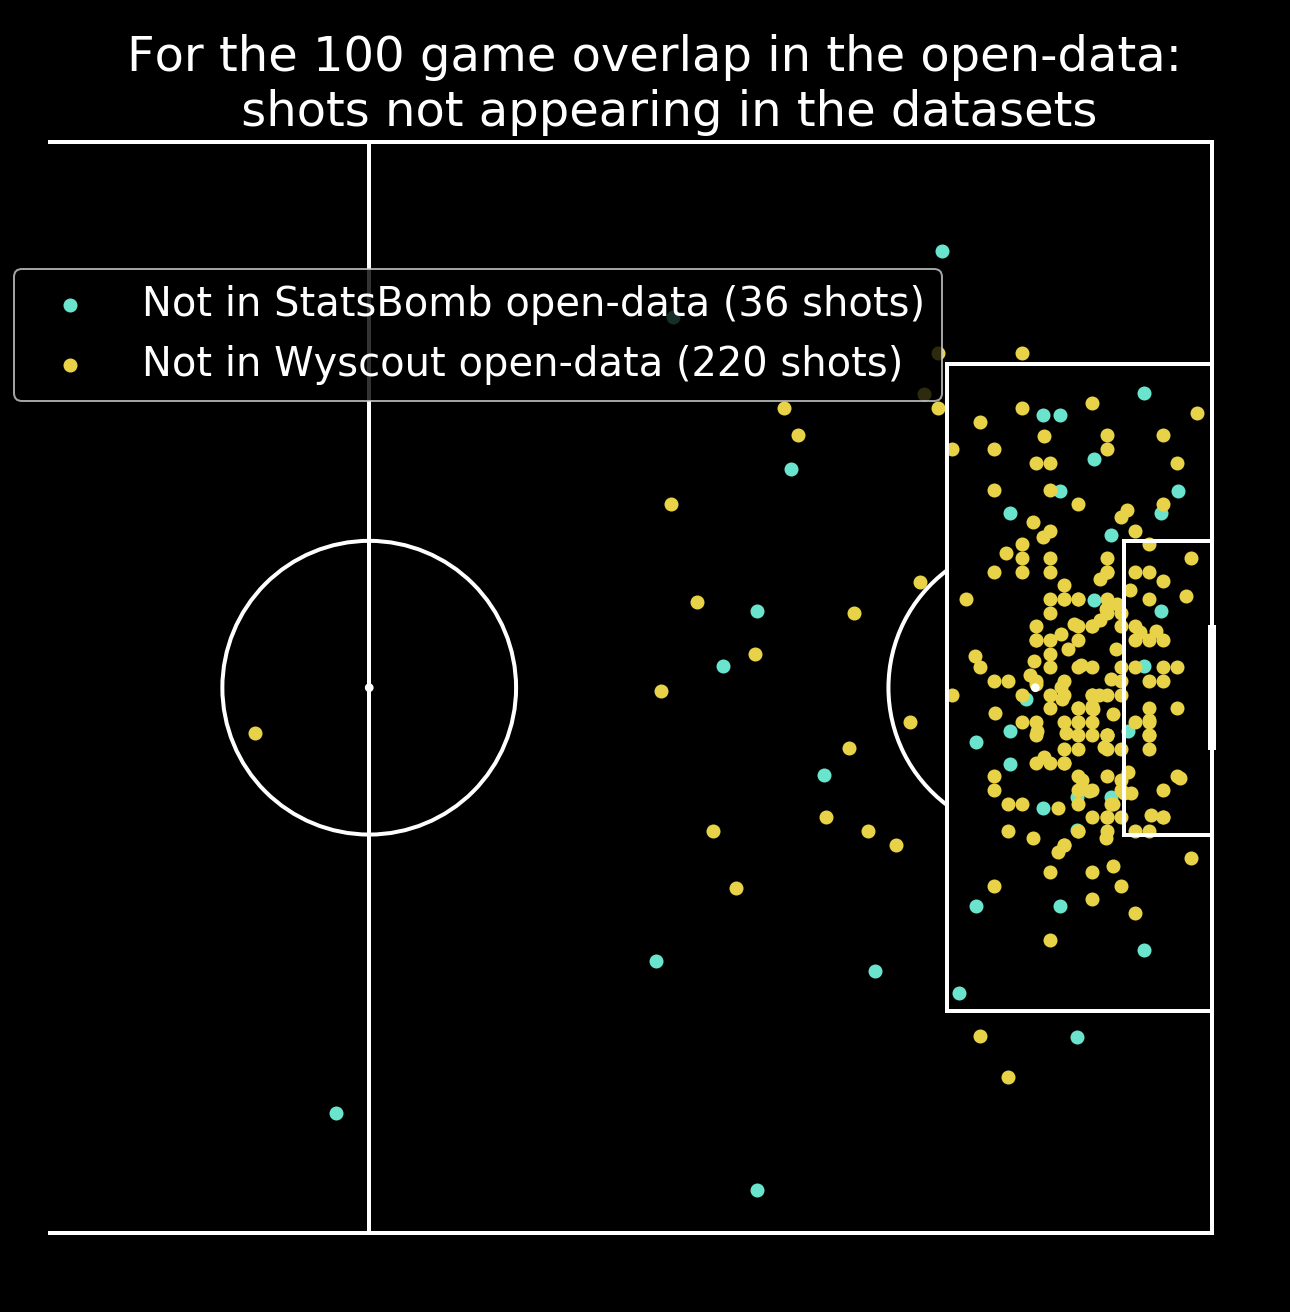

In [24]:
plt.style.use('dark_background')
pitch = Pitch(pitch_type='statsperform', figsize=(16, 9), view='half', pad_left=20, pad_top=8, line_zorder=3,
             constrained_layout=True, tight_layout=False)
fig, ax = pitch.draw()
pitch.scatter(df_wyscout_unmatched.x, df_wyscout_unmatched.y, ax=ax, c='#6ae4cd',
              label=f'Not in StatsBomb open-data ({len(df_wyscout_unmatched)} shots)')
pitch.scatter(df_statsbomb_unmatched.x, df_statsbomb_unmatched.y, ax=ax, c='#e8d247',
              label=f'Not in Wyscout open-data ({len(df_statsbomb_unmatched)} shots)')
ax.legend(fontsize=20, loc='center', bbox_to_anchor=(0.1, 0.5, 0.5, 0.5))
fig.suptitle('For the 100 game overlap in the open-data: \n shots not appearing in the datasets', y=0.98, fontsize=24);
fig.savefig('shot_differences.png', bbox_inches = 'tight', pad_inches = 2)

Plot difference

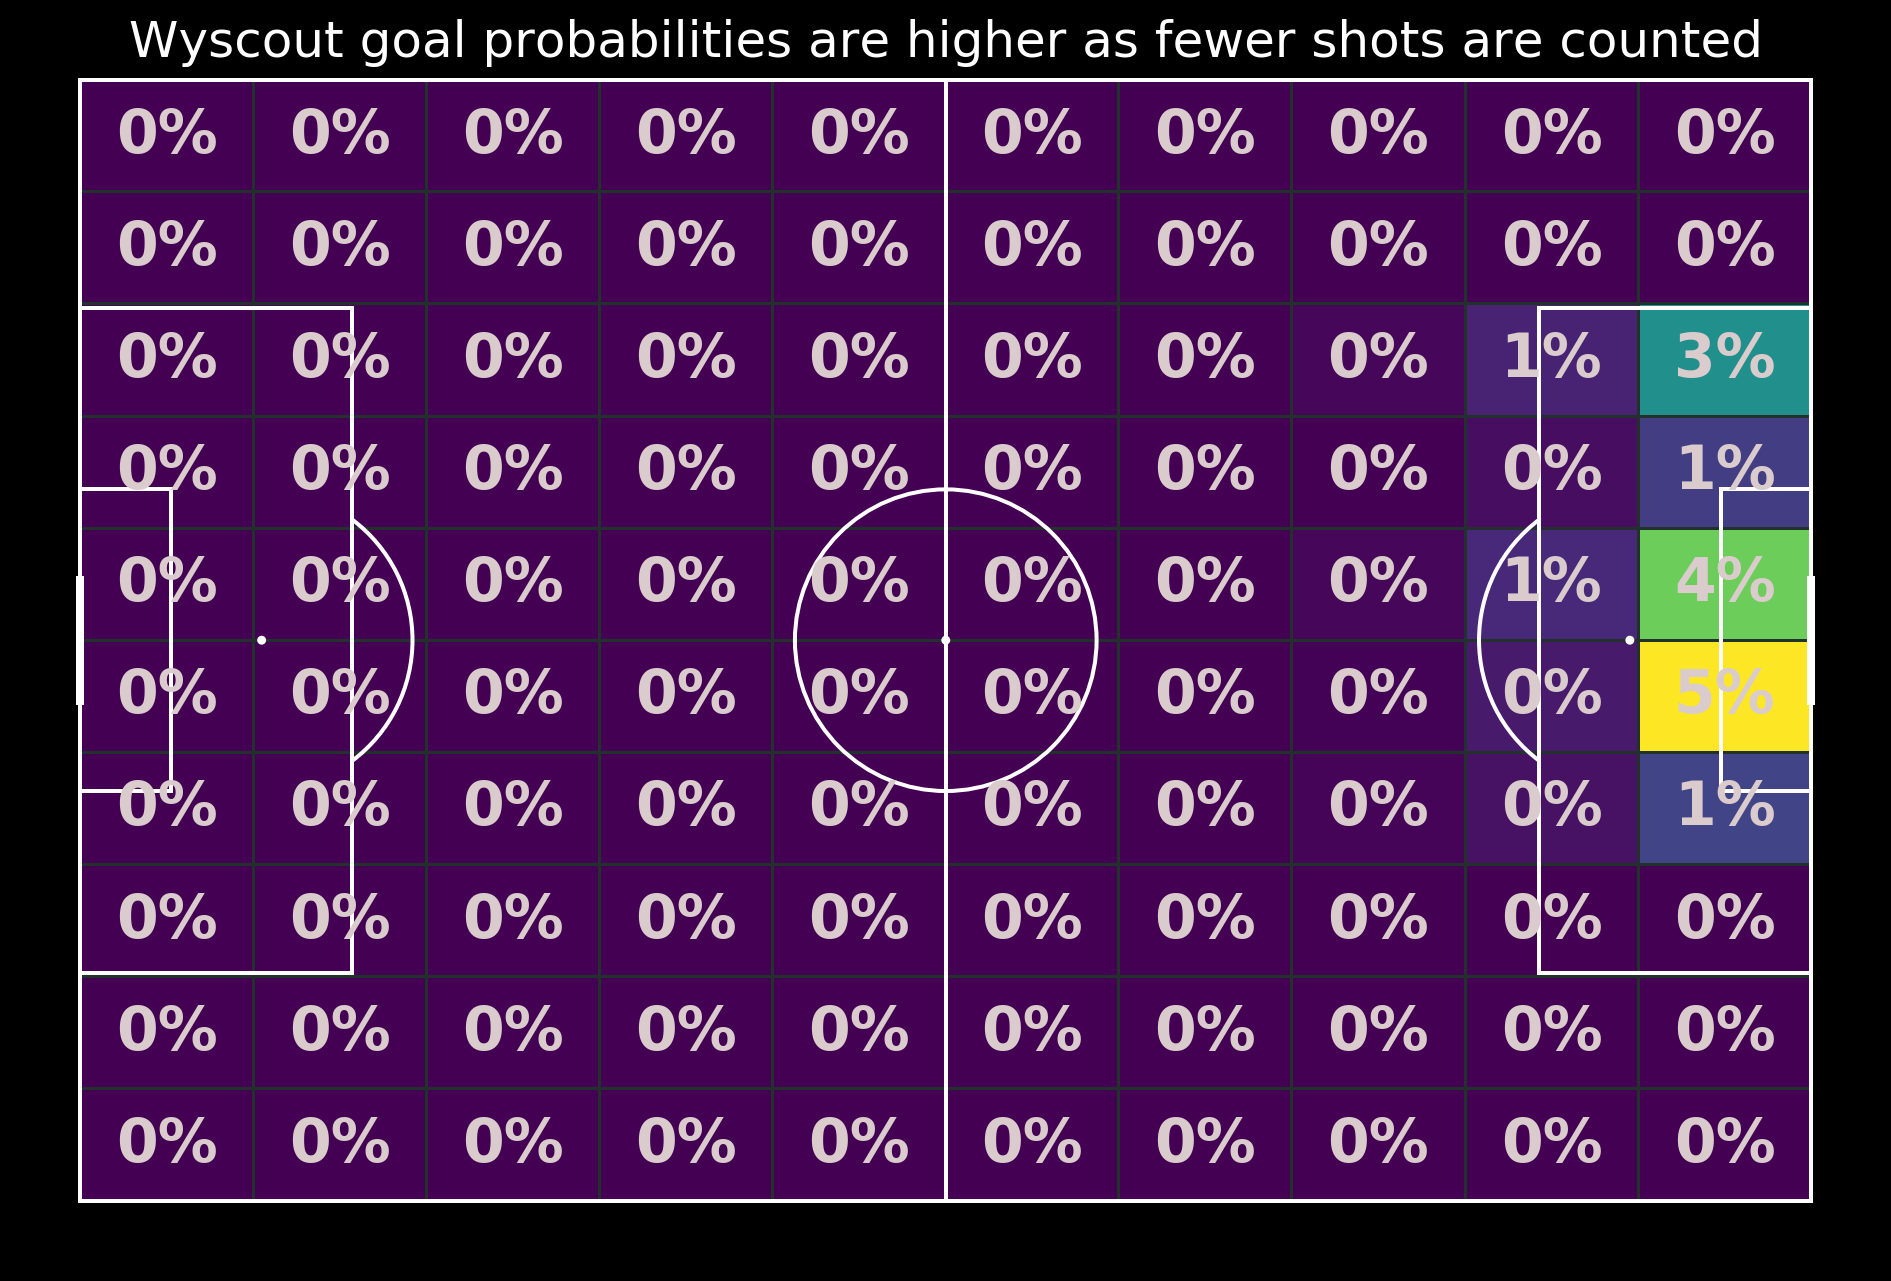

In [25]:
# goal probabilities for all shots
pitch = Pitch(pitch_type='statsperform', figsize=(16, 9), line_zorder=3)
mask_goal = df_statsbomb_shots.outcome_name=='Goal'
bin_statistic_sb = pitch.bin_statistic(df_statsbomb_shots.x,
                                       df_statsbomb_shots.y,
                                       mask_goal,
                                       statistic='mean',
                                       bins=(5, 5))
# goal probabilities for matched shots
mask_goal = df_matched_shots.outcome_name=='Goal'
bin_statistic_match = pitch.bin_statistic(df_matched_shots.x_statsbomb,
                                          df_matched_shots.y_statsbomb,
                                          mask_goal,
                                          statistic='mean',
                                          bins=(5, 5))
# goal probabilities for all shots
mask_goal = df_statsbomb_shots.outcome_name=='Goal'
bin_statistic_sb = pitch.bin_statistic(df_statsbomb_shots.x,
                                       df_statsbomb_shots.y,
                                       mask_goal,
                                       statistic='mean',
                                       bins=(10, 10))
# goal probabilities for matched shots
mask_goal = df_matched_shots.outcome_name=='Goal'
bin_statistic_match = pitch.bin_statistic(df_matched_shots.x_statsbomb,
                                          df_matched_shots.y_statsbomb,
                                          mask_goal,
                                          statistic='mean',
                                          bins=(10, 10))
# calculate difference, i.e. what would happen if only have wyscout shots
bin_statistic_sb['statistic'] = np.nan_to_num(bin_statistic_match['statistic']) - np.nan_to_num(bin_statistic_sb['statistic'])
fig, ax = pitch.draw()
pcm = pitch.heatmap(bin_statistic_sb, ax=ax, cmap='viridis', edgecolors='#22312b', zorder=1)
bin_statistic_sb['statistic'] = (pd.DataFrame(bin_statistic_sb['statistic'])
                                 .applymap(lambda x: '{:.0%}'.format(x))
                                 .values)
label = pitch.label_heatmap(bin_statistic_sb, color='#DACCCC', fontsize=30, ax=ax, ha='center', va='center', fontweight='bold')
fig.suptitle('Wyscout goal probabilities are higher as fewer shots are counted', fontsize=25)
fig.savefig('shot_probabilities.png', bbox_inches = 'tight', pad_inches = 2)

Average distance between StatsBomb and Wyscout shot locations

In [26]:
distance = ((df_matched_shots.x_statsbomb - df_matched_shots.x_wyscout)**2 +
            (df_matched_shots.y_statsbomb - df_matched_shots.y_wyscout)**2)**0.5

In [27]:
x_diff = df_matched_shots.x_statsbomb - df_matched_shots.x_wyscout
y_diff = df_matched_shots.y_statsbomb - df_matched_shots.y_wyscout

In [28]:
pd.DataFrame({'x_diff': x_diff, 'y_diff': y_diff, 'distance': distance}).describe()

,x_diff,y_diff,distance
count,2384.000000,2384.000000,2384.000000
mean,1.639395,-0.248992,3.557913
std,3.673556,3.081874,3.616582
min,-7.787500,-17.935000,0.121989
25%,0.043750,-2.125000,1.839465
50%,1.312500,-0.297500,3.049718
75%,2.843750,1.615000,4.525900
max,85.312500,30.855000,86.780607


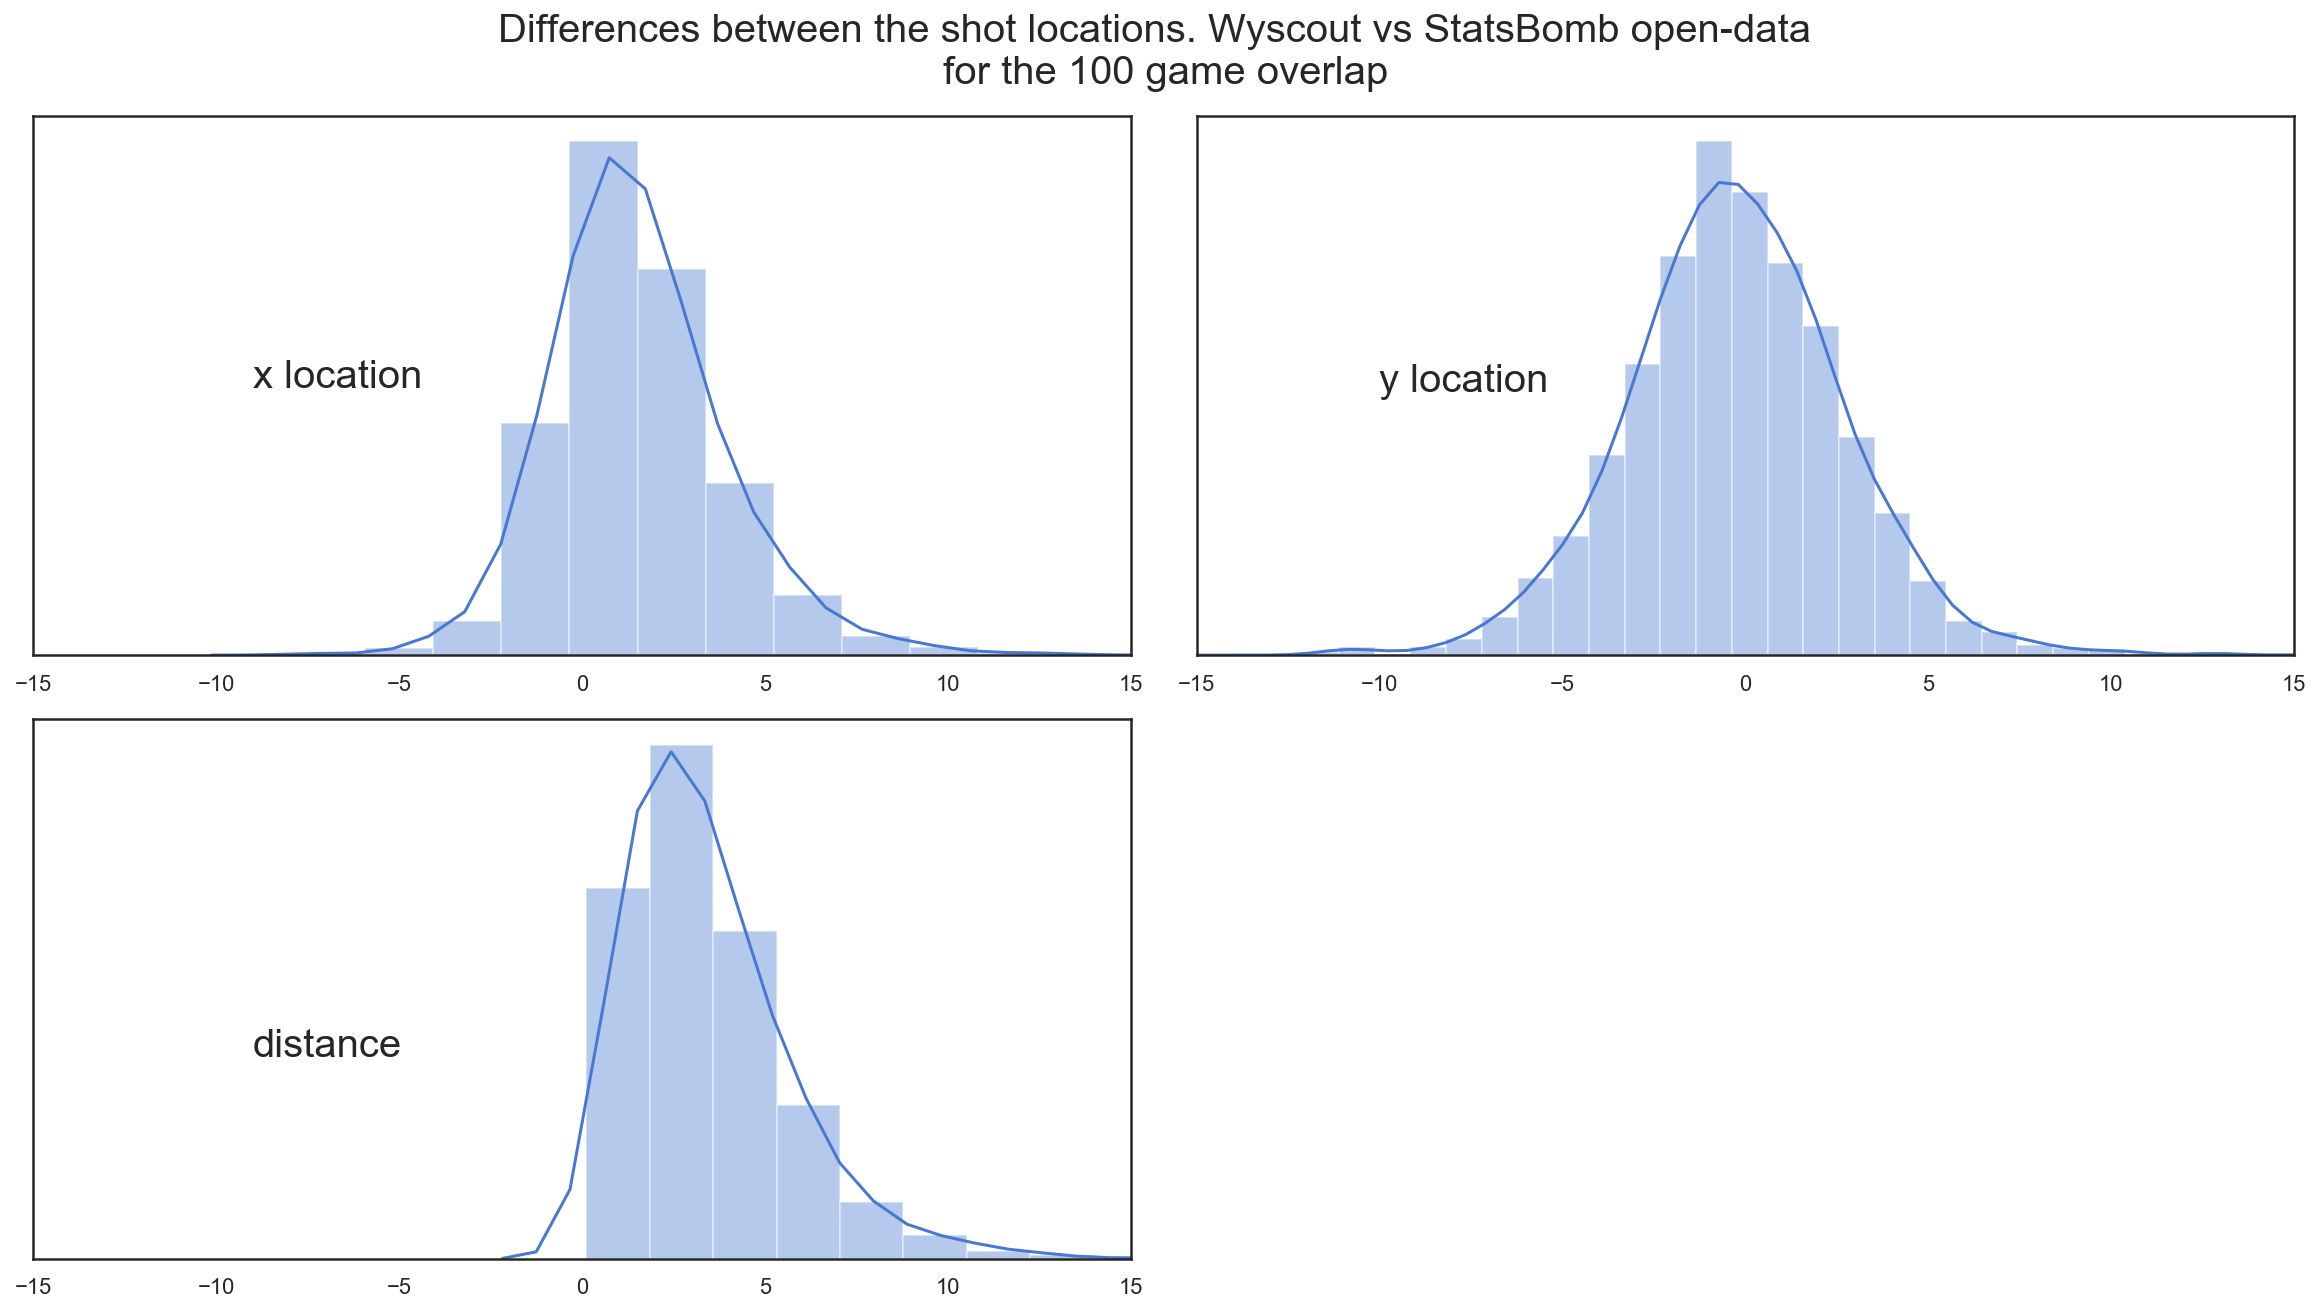

In [29]:
sns.set(style="white", palette="muted", color_codes=True)
fig, ax  = plt.subplots(2, 2, figsize=(16, 9), constrained_layout=True)
sns.distplot(x_diff, ax=ax[0, 0])
sns.distplot(y_diff, ax=ax[0, 1])
sns.distplot(distance, ax=ax[1, 0])
plt.setp(ax, yticks=[])
ax[0, 0].set_xlim(-15, 15)
ax[0, 0].annotate('x location', (-9, 0.1), fontsize=20)
ax[0, 1].set_xlim(-15, 15)
ax[0, 1].annotate('y location', (-10, 0.08), fontsize=20)
ax[1, 0].set_xlim(-15, 15)
ax[1, 0].annotate('distance', (-9, 0.08), fontsize=20)
ax[1, 1].remove()
fig.suptitle('Differences between the shot locations. Wyscout vs StatsBomb open-data \n for the 100 game overlap', fontsize=20)
fig.savefig('distance_differences.png', bbox_inches = 'tight', pad_inches = 2)

Plots example match

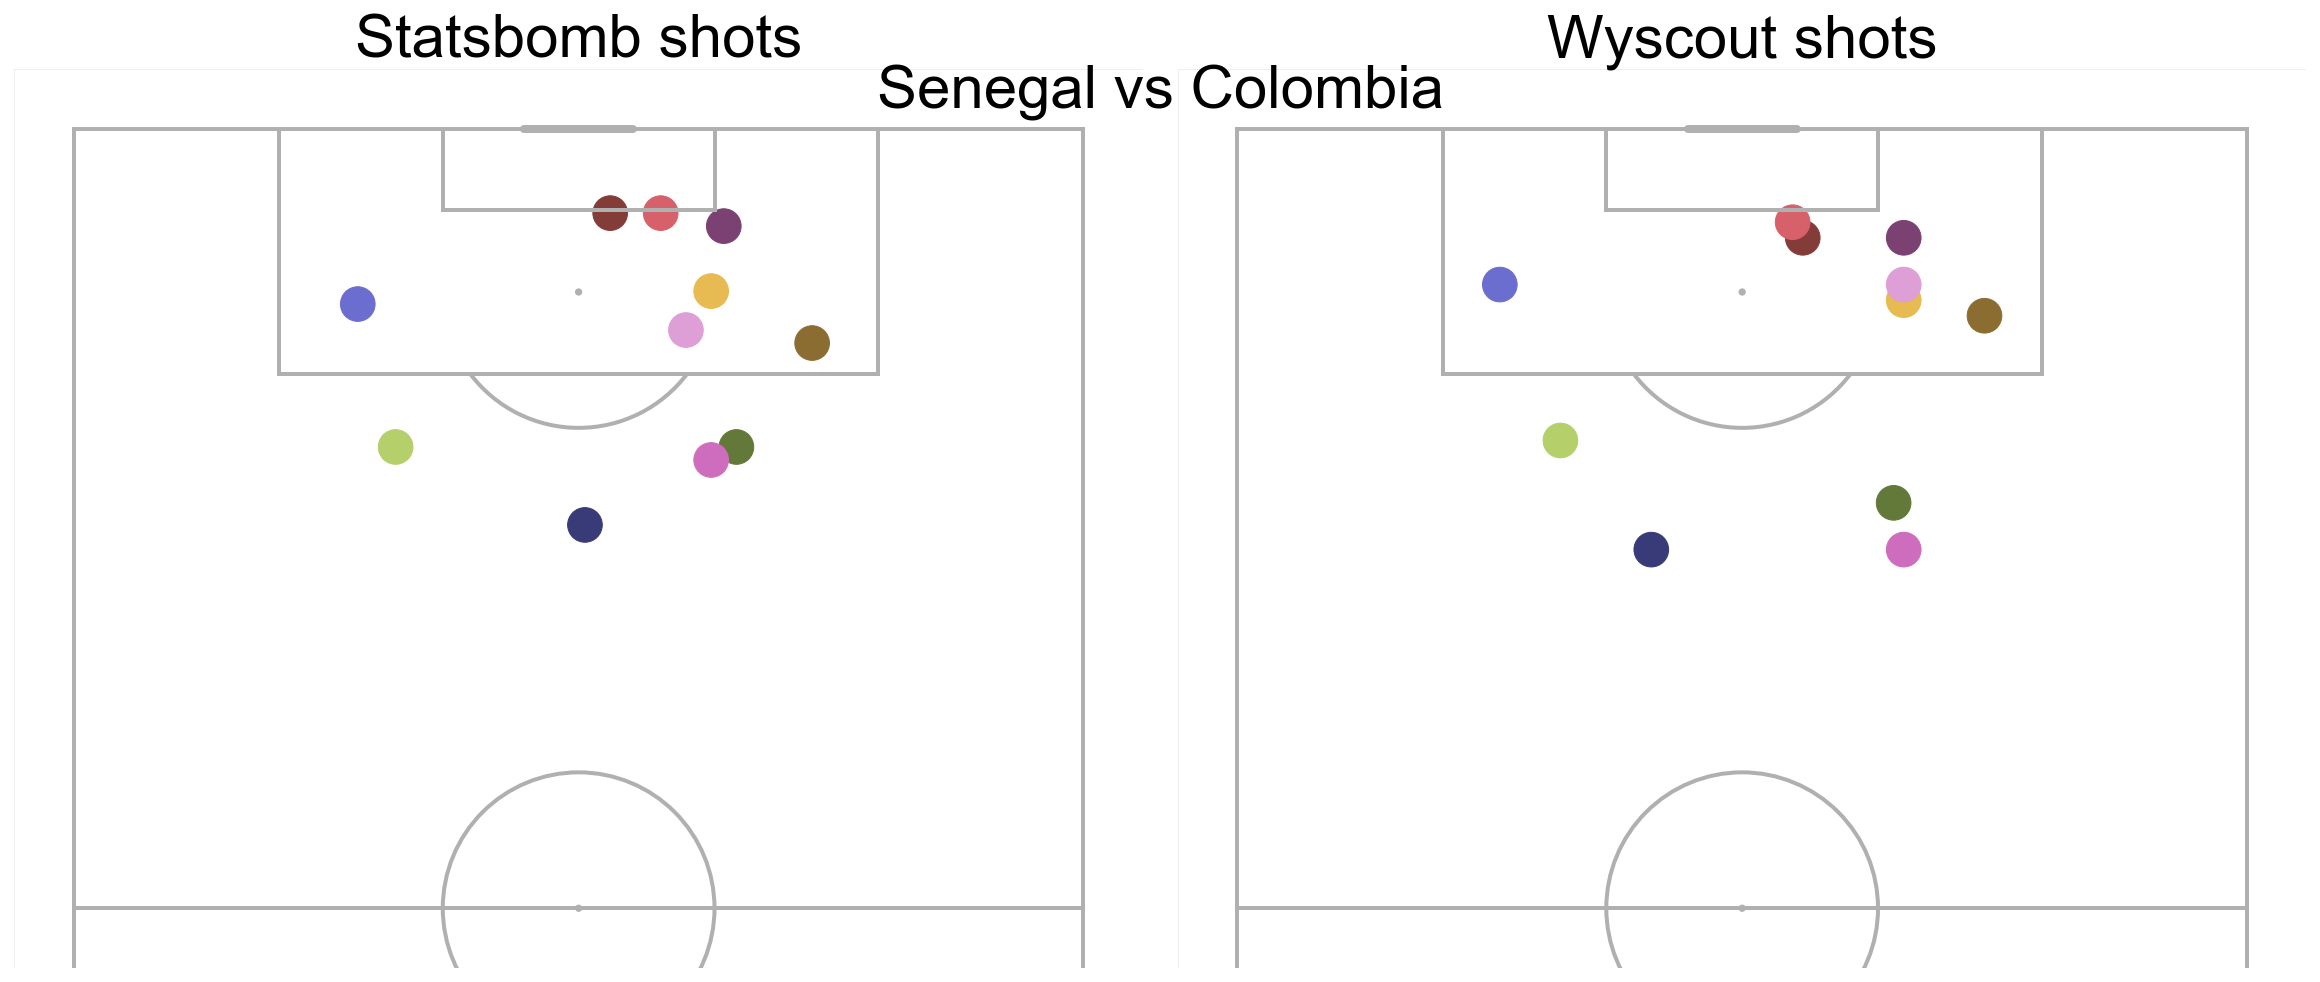

In [31]:
plt.style.use('ggplot')

all_ids = df_statsbomb_shots.match_id_wyscout.unique()

subset = df_matched_shots[df_matched_shots.match_id_wyscout == all_ids[1]].copy()
subset_match = df_wyscout_match[df_wyscout_match.match_id == all_ids[1]]
team1 = subset_match.home_team_name.values[0]
team2 = subset_match.away_team_name.values[0]

fig, ax  = plt.subplots(1, 2, figsize=(16, 9), constrained_layout=True)
fig.suptitle(f'{team1} vs {team2}', fontsize=30, y=0.85, color='black')

pitch_statsperform.draw(ax=ax[0])
pitch_statsperform.scatter(subset.x_statsbomb, subset.y_statsbomb, c=np.arange(subset.y_statsbomb.size),
                           cmap='tab20b', ax=ax[0], s=300)
ax[0].set_title('Statsbomb shots', fontsize=30, color='black')

pitch_statsperform.draw(ax=ax[1])
pitch_statsperform.scatter(subset.x_wyscout, subset.y_wyscout, c=np.arange(subset.y_statsbomb.size),
                           cmap='tab20b', ax=ax[1], s=300)
ax[1].set_title('Wyscout shots', fontsize=30, color='black')
fig.savefig('comparison.png')